# 0. Load the necessary functions

In [109]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl
from sklearn import neighbors
import copy
from sklearn.cluster import DBSCAN
import emcee
import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, [1,500], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

def foo(a, b):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

# 1. Load the cable geometry and imagery

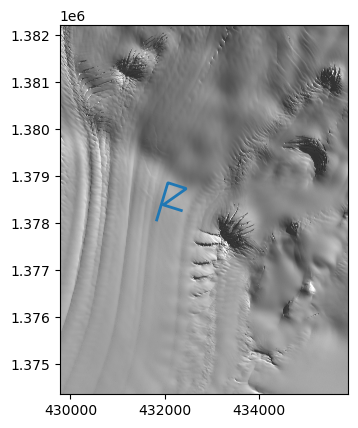

In [2]:
cable_loc = pd.read_csv('eastwind_coordinates_utm59s.csv', header=None)
cable_loc.rename(columns={0:'name', 1:'y', 2:'x', 3:'z'}, inplace=True)

cable_sections = [[0,132],[133,136], [137,192],[193,217],[218,285],[286,291],[292,350]]
cable_loc_names = [['D_0','D_12'],['D_12','D_17'], ['D_17','D_26'],['D_26','D_31'],['D_31','D_40'],['D_40','D_43'],['D_43','D_49']]

channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0]
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0]

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0]
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0]

    z_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'z'].iloc[0]
    z_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'z'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)
    z_vals = np.linspace(z_start, z_end, chan_num[1]-chan_num[0]+1)

    for x,y,z in zip(x_vals, y_vals, z_vals):
        channel_locations.append([x,y,z])

channel_locations = np.asarray(channel_locations)


# Specify the path to the GeoPackage file
gpkg_path = "imagery/eastwind_image_reproject_AOI_clip.tif"

fig,ax = plt.subplots()


# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed


ax.plot(channel_locations[:,0], channel_locations[:,1], lw=2)

plt.show()

# 2. Load the manual picks

In [3]:
manual_picks_files = glob('manual_event_picks_*')

manual_picks_dict = {}
for i in manual_picks_files:
    with open(i,'rb') as f:
        manual_picks = pkl.load(f)
        manual_picks_dict.update(manual_picks)


# 3. Create the MC functions.
Here, we will adjust for the number of picked phases

### 3.1 priors, ie the range we want to search in

In [4]:
top_lim = 1390000
bottom_lim = 1370000

right_lim = 436000
left_lim = 428000

depth_lim = -1000
height_lim = 100

c1_wavespeed_min = 100
c1_wavespeed_max = 5000

c2_wavespeed_min = 100
c2_wavespeed_max = 5000

In [11]:


### Functions ###
def log_prior(theta, picks):

    if theta.shape[-1] == 6:

        s_x,s_y,s_z,t_offset,c1,c2 = theta

        min_offset = np.array(picks[0][1]).min() - 5
        max_offset = np.array(picks[0][1]).min() + 0
        if (left_lim < s_x < right_lim 
        and bottom_lim < s_y < top_lim 
        and depth_lim < s_z < height_lim 
        and min_offset < t_offset < max_offset 
        and c1_wavespeed_min < c1 < c1_wavespeed_max 
        and c2_wavespeed_min < c2 < c2_wavespeed_max):
            return 0.0
        return -np.inf
    if theta.shape[-1] == 5:

        s_x,s_y,s_z,t_offset,c1 = theta

        min_offset = np.array(picks[0][1]).min() - 5
        max_offset = np.array(picks[0][1]).min() + 0
        if (left_lim < s_x < right_lim 
        and bottom_lim < s_y < top_lim 
        and depth_lim < s_z < height_lim 
        and min_offset < t_offset < max_offset 
        and c1_wavespeed_min < c1 < c1_wavespeed_max):
            return 0.0
        return -np.inf

def log_likelihood(theta, picks):
    if theta.shape[-1] == 6:
        s_x,s_y,s_z,t_offset,c1,c2 = theta
        chans_of_picks_c1 = np.array(picks[0][0], dtype=int)
        chans_of_picks_c2 = np.array(picks[1][0], dtype=int)

        distance_c1 = np.sqrt((channel_locations[chans_of_picks_c1,0]-s_x)**2 + (channel_locations[chans_of_picks_c1,1]-s_y)**2 + (channel_locations[chans_of_picks_c1,2]-s_z)**2)   
        distance_c2 = np.sqrt((channel_locations[chans_of_picks_c2,0]-s_x)**2 + (channel_locations[chans_of_picks_c2,1]-s_y)**2 + (channel_locations[chans_of_picks_c2,2]-s_z)**2)   

        model_c1 = distance_c1/c1 + t_offset
        model_c2 = distance_c2/c2 + t_offset

        best_line_coeffs = np.poly1d(np.polyfit(chans_of_picks_c1, picks[0][1], 5))
        fit_line = np.polyval(best_line_coeffs, chans_of_picks_c1)
        pick_residual = picks[0][1] - fit_line
        sigma = np.std(pick_residual)

        sigma2 = sigma**2
        #model =  t_offset + np.linalg.norm(channel_locations[chans_of_picks,:] - np.array([s_x, s_y]), axis=0) / c

        c1_model_residual = np.sum((model_c1 - picks[0][1])**2)
        c2_model_residual = np.sum((model_c2 - picks[1][1])**2)
        ll = -0.5 * np.sum((c1_model_residual + c2_model_residual) / (4 * sigma2) + np.log(2 * np.pi * sigma2))

        return ll
    
    if theta.shape[-1] == 5:
        s_x,s_y,s_z,t_offset,c1 = theta
        chans_of_picks_c1 = np.array(picks[0][0], dtype=int)
  

        distance_c1 = np.sqrt((channel_locations[chans_of_picks_c1,0]-s_x)**2 + (channel_locations[chans_of_picks_c1,1]-s_y)**2 + (channel_locations[chans_of_picks_c1,2]-s_z)**2)   


        model_c1 = distance_c1/c1 + t_offset


        best_line_coeffs = np.poly1d(np.polyfit(chans_of_picks_c1, picks[0][1], 5))
        fit_line = np.polyval(best_line_coeffs, chans_of_picks_c1)
        pick_residual = picks[0][1] - fit_line
        sigma = np.std(pick_residual)

        sigma2 = sigma**2
        #model =  t_offset + np.linalg.norm(channel_locations[chans_of_picks,:] - np.array([s_x, s_y]), axis=0) / c


        ll = - 0.5 * np.sum((model_c1 - picks[0][1])**2 / sigma2 + np.log(sigma2))

        return ll
def log_probability(theta, picks):
    lp = log_prior(theta, picks)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    return lp + log_likelihood(theta, picks), lp + log_likelihood(theta, picks)

dtype = [("log_prob", float)]

# 4. Make an initial guess on the source location and wavespeed. Define how many walkers we want

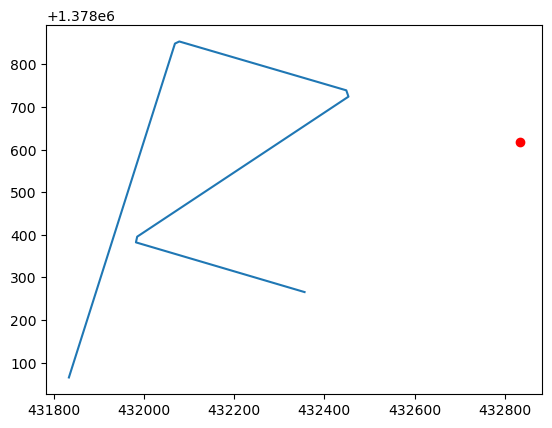

In [12]:
s_x_init = 432833.2600664
s_y_init = 1378618.37797727
s_z_init = -10

c1_init = 3000
c2_init = 2000


num_resets = 32

fig,ax = plt.subplots()
ax.plot(channel_locations[:,0], channel_locations[:,1])
ax.scatter([s_x_init], [s_y_init], c='red')

# 5. Loop over all events

In [16]:
flat_samples_all = {}

for n,event in tqdm(enumerate(manual_picks_dict)):

    # if n == 1:
    #     break

    picks_ = manual_picks_dict[event]

    picks = []
    for i in picks_:
        picks.append(np.asarray([[k[0], k[1]] for k in i]).T)
    
    offset_init = np.array(picks[0][1]).min() - 1



    # If multiple wave phases were picked, do this . . .
    if len(picks) == 2:
    ## make the initial guess array ##
        init_guesses = np.array([s_x_init, s_y_init, s_z_init, offset_init, c1_init, c2_init])

        initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e1, 1e-5, 1e2, 1e2])

        nwalkers, ndim = initial.shape

    # If only one wave phase were picked, do this .. . 
    if len(picks) == 1:
        init_guesses = np.array([s_x_init, s_y_init, s_z_init, offset_init, c1_init])

        initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e1, 1e-6, 1e2])

        nwalkers, ndim = initial.shape


    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=[picks]
    )
    sampler.run_mcmc(initial, 3000, progress=True);

    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

    flat_samples_all[event] = flat_samples

100%|██████████| 3000/3000 [00:38<00:00, 77.65it/s]
1it [00:38, 38.66s/it]/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpd

In [ ]:
# with open('manual_picks_all_events_MC.pkl', 'wb') as f:
#     pkl.dump(flat_samples_all, f)

# 6. Load the saved locations from all the events

In [18]:
with open('manual_picks_all_events_MC.pkl', 'rb') as f:
    MC_flat_samples_all = pkl.load(f)

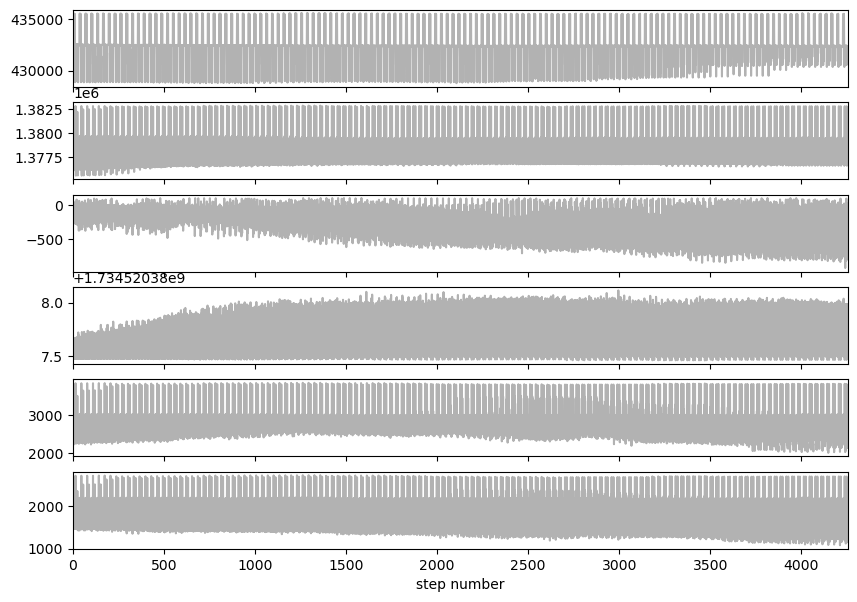

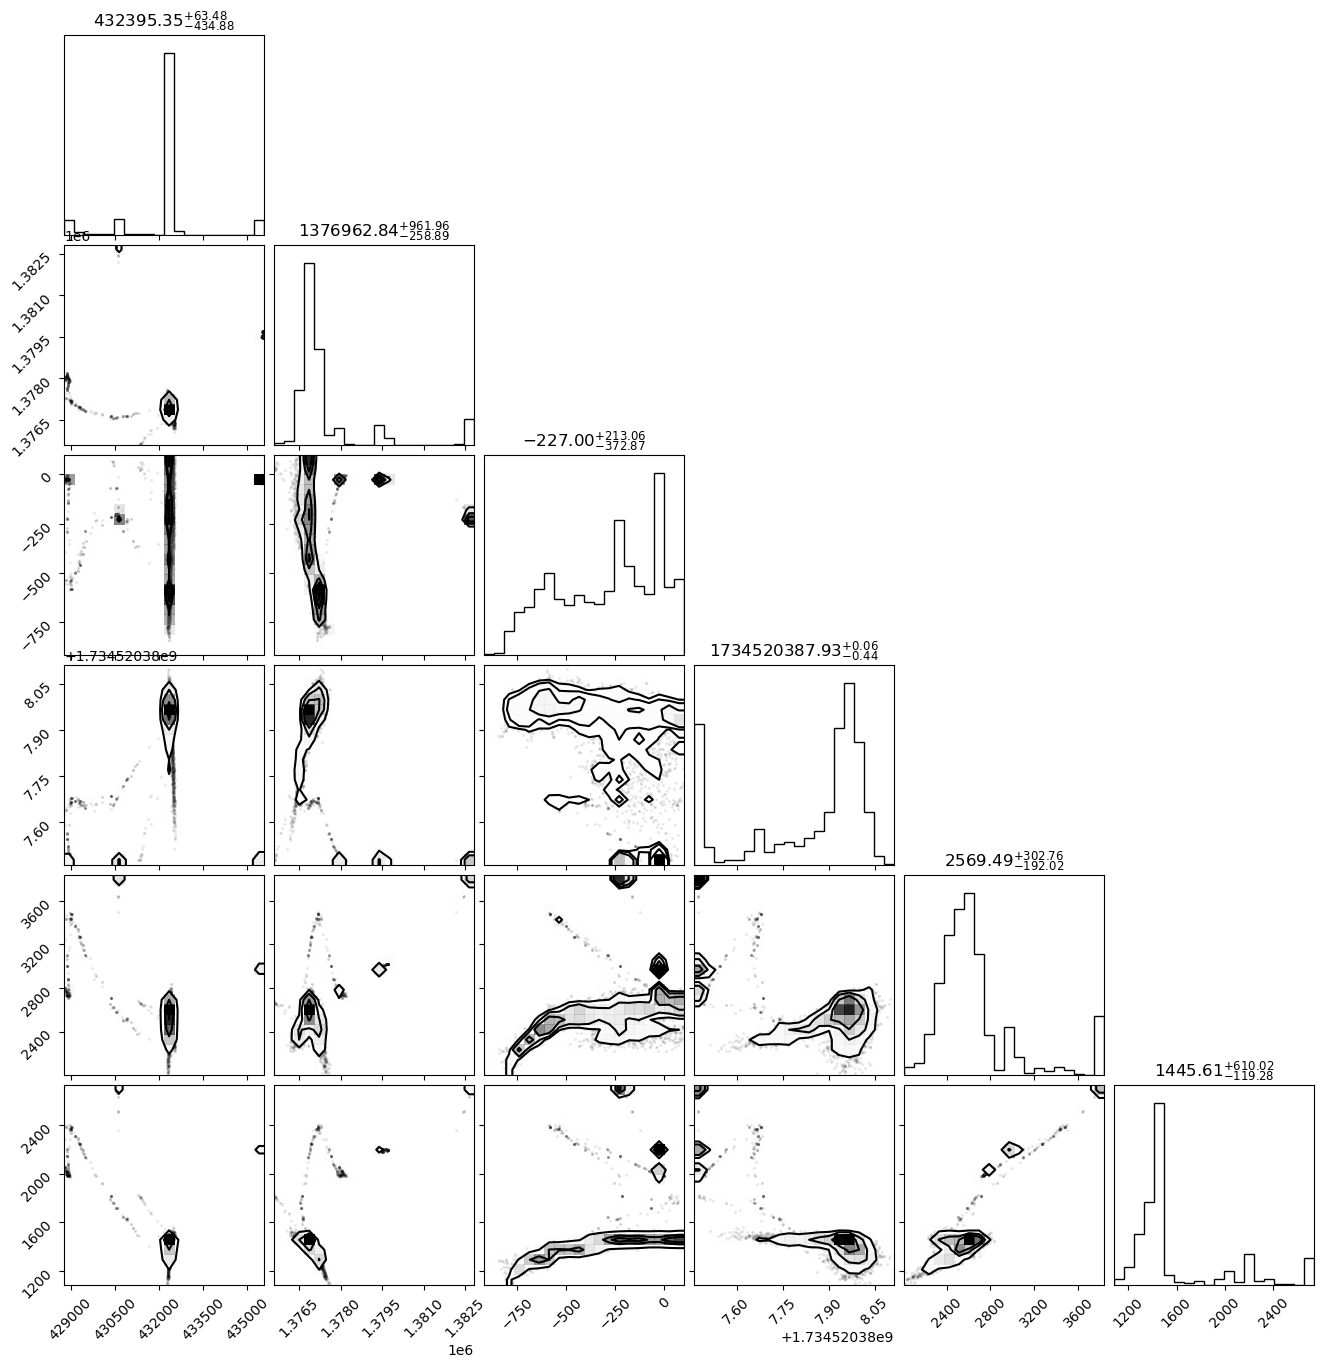

In [27]:
flat_samples = MC_flat_samples_all['Event 149']

fig, axes = plt.subplots(flat_samples.shape[-1], figsize=(10, 7), sharex=True)


for i in range(flat_samples.shape[-1]):
    ax = axes[i]
    ax.plot(flat_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(flat_samples))

    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

import corner

fig = corner.corner(
    flat_samples, show_titles=True
);

# 7. The the best locations

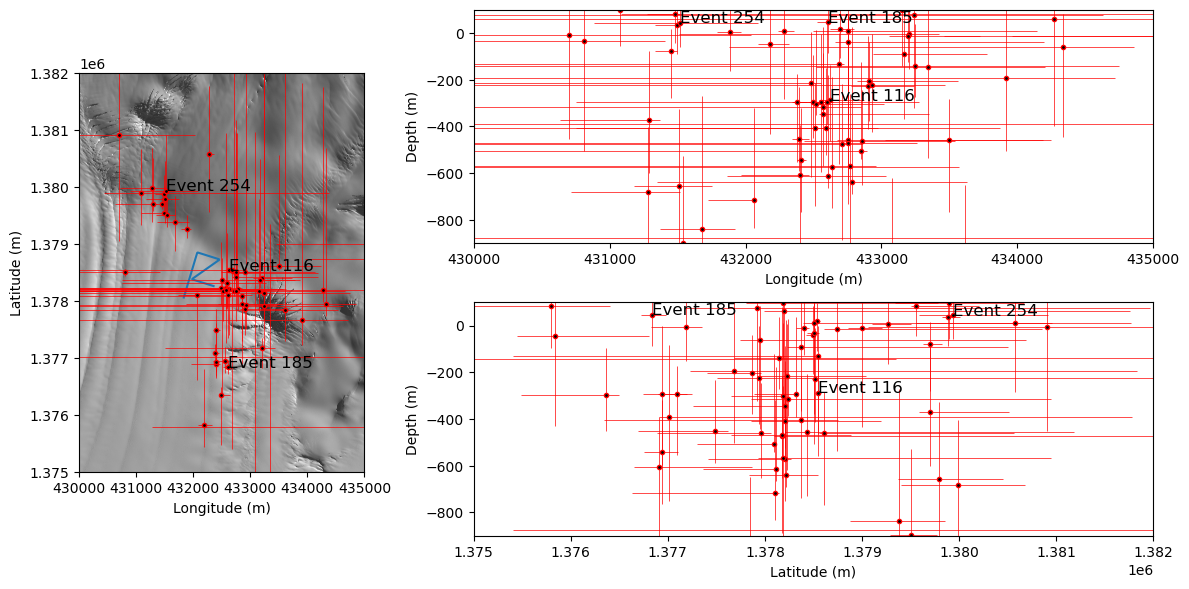

In [225]:

plt.figure(figsize=(12, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)  # First plot spanning (1,1) and (2,1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)  # Second plot at (2,2)
ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)  # Third plot at (2,3)

# fig,ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 2,2], 'height_ratios': [1]})

ax = [ax1, ax2, ax3]
show(image_data, transform=src.transform, ax=ax[0]) 
ax[0].plot(channel_locations[:,0], channel_locations[:,1])

for event in MC_flat_samples_all:
    flat_samples = MC_flat_samples_all[event]
    
    median_x = np.median(flat_samples[:,0])
    median_y = np.median(flat_samples[:,1])
    median_z = np.median(flat_samples[:,2])
    median_offset = np.median(flat_samples[:,3])
    median_c = np.median(flat_samples[:,4])

    xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
    z_locs = gaussian_kde(xy_locs)(xy_locs)

    cable_mean_x = np.mean(channel_locations[:,0])
    cable_mean_y = np.mean(channel_locations[:,1])

    horizontal_distance = np.sqrt((flat_samples[:,0]-cable_mean_x)**2 + (flat_samples[:,1]-cable_mean_y)**2)

    xyz_locs = np.vstack([horizontal_distance, flat_samples[:,2]])
    depth_locs = gaussian_kde(xyz_locs)(xyz_locs)

    coord_of_best = z_locs.argmax()
    x_best = flat_samples[coord_of_best,0]
    y_best = flat_samples[coord_of_best,1]

    distance_best = np.sqrt((x_best-cable_mean_x)**2 + (y_best-cable_mean_y)**2)
    coord_of_best_z = depth_locs.argmax()
    z_best = flat_samples[coord_of_best_z,2]

    ## if we want the best x instead of distance

    xyz2_locs = np.vstack([flat_samples[:,0], flat_samples[:,2]])
    depth2_locs = gaussian_kde(xyz2_locs)(xyz2_locs)
    coord_of_best_z2 = depth2_locs.argmax()
    z2_best = flat_samples[coord_of_best_z2,2]

    percentiles = [16, 50, 84]  # Common percentiles for 1-sigma credible interval

    # Compute percentiles for each parameter
    param_percentiles = np.percentile(flat_samples, percentiles, axis=0)

    medians = param_percentiles[1]
    lower_errors = medians - param_percentiles[0]
    upper_errors = param_percentiles[2] - medians


    x_err = [[lower_errors[0]], [upper_errors[0]]]
    y_err = [[lower_errors[1]], [upper_errors[1]]]
    z_err = [[lower_errors[2]], [upper_errors[2]]]

    ax[0].errorbar([x_best], [y_best], 
                   xerr=x_err, yerr=y_err, 
                   fmt = '.',c='red', label='Best Inversion', elinewidth=0.5, mfc='black')
    #ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 1)
    # ax[0].scatter([x_best], [y_best], c='red', label='Best Inversion')

    #ax[1].scatter(horizontal_distance, flat_samples[:,2], c=depth_locs, s=2, alpha = 1)
    #ax[1].scatter([x_best], [z_best], c='red', label='Best Inversion')

    ax[1].errorbar([x_best], [z_best], 
                   xerr=x_err, yerr=z_err, 
                   fmt = '.',c='red', label='Best Inversion', elinewidth=0.5, mfc='black')

    ax[2].errorbar([y_best], [z_best], 
                   xerr=y_err, yerr=z_err, 
                   fmt = '.',c='red', label='Best Inversion', elinewidth=0.5, mfc='black')
    # ax[2].scatter([y_best], [z_best], c='red', label='Best Inversion')

    ax[0].set_ylim([1.375e6, 1.382e6])
    ax[0].set_xlim([4.3e5, 4.35e5])


    ax[1].set_xlim([4.3e5, 4.35e5])
    ax[1].set_ylim([-900, 100])
    
    ax[2].set_xlim([1.375e6, 1.382e6])
    ax[2].set_ylim([-900, 100])

    ax[0].set_xlabel('Longitude (m)')
    ax[0].set_ylabel('Latitude (m)')

    ax[1].set_xlabel('Longitude (m)')
    ax[1].set_ylabel('Depth (m)')

    ax[2].set_xlabel('Latitude (m)')
    ax[2].set_ylabel('Depth (m)')

    # ax[0].annotate(event, (x_best, y_best), fontsize=8)
    # ax[1].annotate(event, (x_best, z_best), fontsize=8)
    # ax[2].annotate(event, (y_best, z_best), fontsize=8)
    if event == 'Event 185':
        ax[0].annotate(event, (x_best, y_best), fontsize=12)
        ax[1].annotate(event, (x_best, z_best), fontsize=12)
        ax[2].annotate(event, (y_best, z_best), fontsize=12)

    if event == 'Event 254':
        ax[0].annotate(event, (x_best, y_best), fontsize=12)
        ax[1].annotate(event, (x_best, z_best), fontsize=12)
        ax[2].annotate(event, (y_best, z_best), fontsize=12)

    if event == 'Event 116':
        ax[0].annotate(event, (x_best, y_best), fontsize=12)
        ax[1].annotate(event, (x_best, z_best), fontsize=12)
        ax[2].annotate(event, (y_best, z_best), fontsize=12)
plt.tight_layout()

# 8. Plot an individual event location

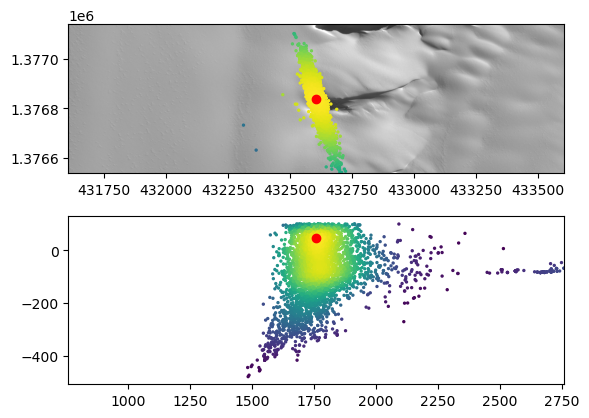

In [224]:
fig,ax = plt.subplots(2,1)

show(image_data, transform=src.transform, ax=ax[0]) 
ax[0].plot(channel_locations[:,0], channel_locations[:,1])


flat_samples = MC_flat_samples_all['Event 185']

median_x = np.median(flat_samples[:,0])
median_y = np.median(flat_samples[:,1])
median_z = np.median(flat_samples[:,2])
median_offset = np.median(flat_samples[:,3])
median_c = np.median(flat_samples[:,4])

xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
z_locs = gaussian_kde(xy_locs)(xy_locs)

cable_mean_x = np.mean(channel_locations[:,0])
cable_mean_y = np.mean(channel_locations[:,1])

horizontal_distance = np.sqrt((flat_samples[:,0]-cable_mean_x)**2 + (flat_samples[:,1]-cable_mean_y)**2)

xyz_locs = np.vstack([horizontal_distance, flat_samples[:,2]])
depth_locs = gaussian_kde(xyz_locs)(xyz_locs)

coord_of_best = z_locs.argmax()
x_best = flat_samples[coord_of_best,0]
y_best = flat_samples[coord_of_best,1]

distance_best = np.sqrt((x_best-cable_mean_x)**2 + (y_best-cable_mean_y)**2)
coord_of_best_z = depth_locs.argmax()
z_best = flat_samples[coord_of_best_z,2]

## if we want the best x instead of distance

xyz2_locs = np.vstack([flat_samples[:,0], flat_samples[:,2]])
depth2_locs = gaussian_kde(xyz2_locs)(xyz2_locs)
coord_of_best_z2 = depth2_locs.argmax()
z2_best = flat_samples[coord_of_best_z2,2]

ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 1)
ax[0].scatter([x_best], [y_best], c='red', label='Best Inversion')
ax[0].set_ylim([y_best-300, y_best+300])
ax[0].set_xlim([x_best-1000, x_best+1000])

ax[1].scatter(horizontal_distance, flat_samples[:,2], c=depth_locs, s=2, alpha = 1)
ax[1].scatter(distance_best, [z_best], c='red', label='Best Inversion')
ax[1].set_xlim([distance_best-1000, distance_best+1000])

plt.show()

# 9. Do the MC on a single event to get the MC plot for a figure

### 9.1 Get the picks from an event

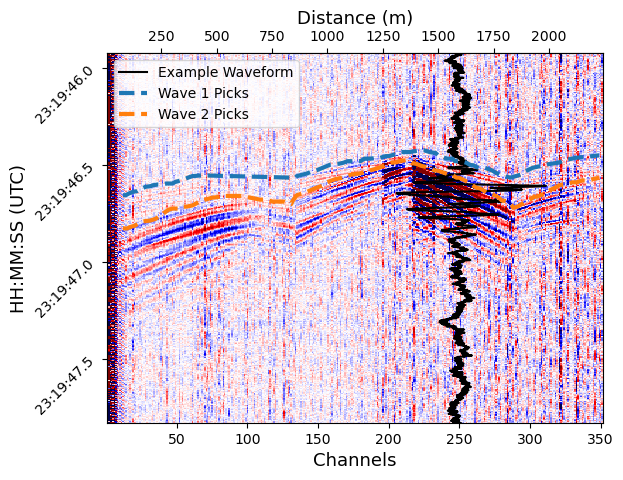

In [151]:
fig,ax = plt.subplots()
ax.yaxis.set_major_formatter(FuncFormatter(foo))
event_nums = list(manual_picks_dict.keys())

event_num = 0 # 0 through 64

event_num = int(event_nums[event_num][-3:])
single_event = manual_picks_dict['Event '+str(event_num)]


### Below is just for plotting purposes ###
time_to_get = datetime.datetime.utcfromtimestamp(single_event[0][0][1])
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time

f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

im = ax.pcolormesh(channels, times, filtered, vmin=-0.05, vmax=0.05, cmap='seismic')

chan_to_plot = 250
ax.plot(filtered[:,chan_to_plot]*500+chan_to_plot, times, c='black', label='Example Waveform')
picks = []
for i in single_event:
    picks.append(np.asarray([[k[0], k[1]] for k in i]).T)

for i, wave_type in zip(picks,['Wave 1 Picks', 'Wave 2 Picks']):
    picks_datetime = np.array([datetime.datetime.utcfromtimestamp(k) for k in i[1]])
    ax.plot(i[0],picks_datetime, label = wave_type, ls='--',lw=3)


ax_top_label = ax.secondary_xaxis('top', functions=(lambda channels: channels * dx, lambda channels: channels / dx))
ax_top_label.set_xlabel('Distance (m)', fontsize=13)

ax.set_ylim([datetime.datetime.utcfromtimestamp(picks[0][1].min()) - datetime.timedelta(seconds=0.5), datetime.datetime.utcfromtimestamp(picks[1][1].max())+ datetime.timedelta(seconds=1)])

ax.invert_yaxis()
ax.legend(loc='upper left')
ax.set_ylabel('HH:MM:SS (UTC)', fontsize=13)
ax.set_xlabel('Channels', fontsize=13)
ax.tick_params(axis='y', labelrotation=45)

plt.show()

### 9.2 Make an initial guess and define the number of walkers for the MC

In [152]:
s_x_init = 432833.2600664
s_y_init = 1378618.37797727
s_z_init = -10

c1_init = 3000
c2_init = 2000


num_resets = 32

### 9.3 Initialize the MC

In [153]:
picks = []
for i in single_event:
    picks.append(np.asarray([[k[0], k[1]] for k in i]).T)

offset_init = np.array(picks[0][1]).min() - 1



# If multiple wave phases were picked, do this . . .
if len(picks) == 2:
## make the initial guess array ##
    init_guesses = np.array([s_x_init, s_y_init, s_z_init, offset_init, c1_init, c2_init])

    initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e1, 1e-5, 1e2, 1e2])

    nwalkers, ndim = initial.shape

# If only one wave phase were picked, do this .. . 
if len(picks) == 1:
    init_guesses = np.array([s_x_init, s_y_init, s_z_init, offset_init, c1_init])

    initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e1, 1e-6, 1e2])

    nwalkers, ndim = initial.shape

### 9.4 Run the MC

In [154]:
### Run the MCMC  on just one for a test ###

nwalkers, ndim = initial.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=[picks], blobs_dtype = dtype
)
sampler.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:56<00:00, 87.83it/s]


### 9.5 Plot the MC sampling

In [155]:
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
print(flat_samples.shape)

(4256, 6)


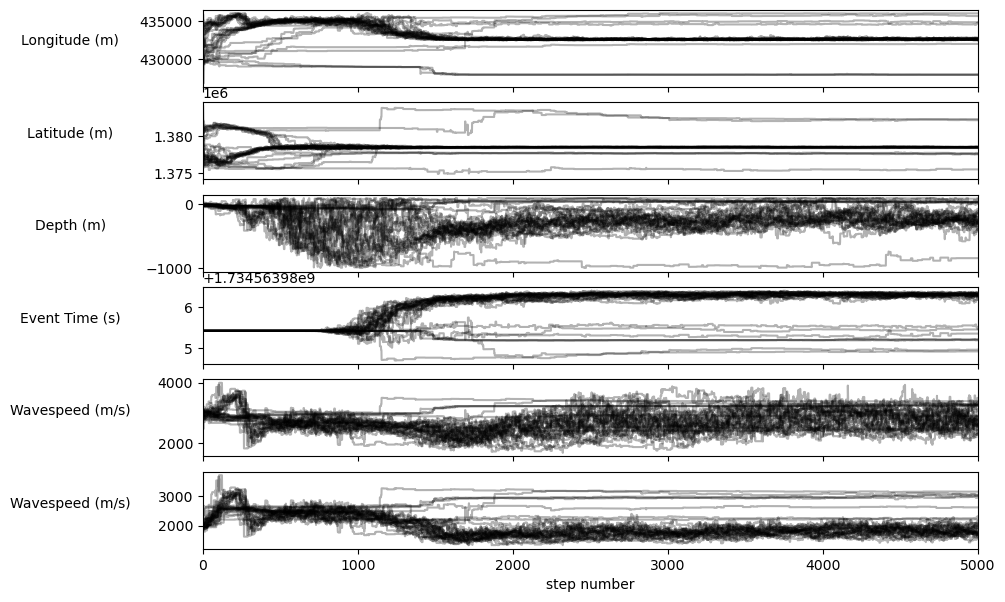

In [156]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['Longitude (m)', 'Latitude (m)', 'Depth (m)', 'Event Time (s)', 'Wavespeed (m/s)', 'Wavespeed (m/s)']
for i, label in zip(range(ndim), labels):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(label, rotation=0, labelpad=50)

    # ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# import corner

# fig = corner.corner(
#     flat_samples, show_titles=True
# );

fig.align_ylabels()

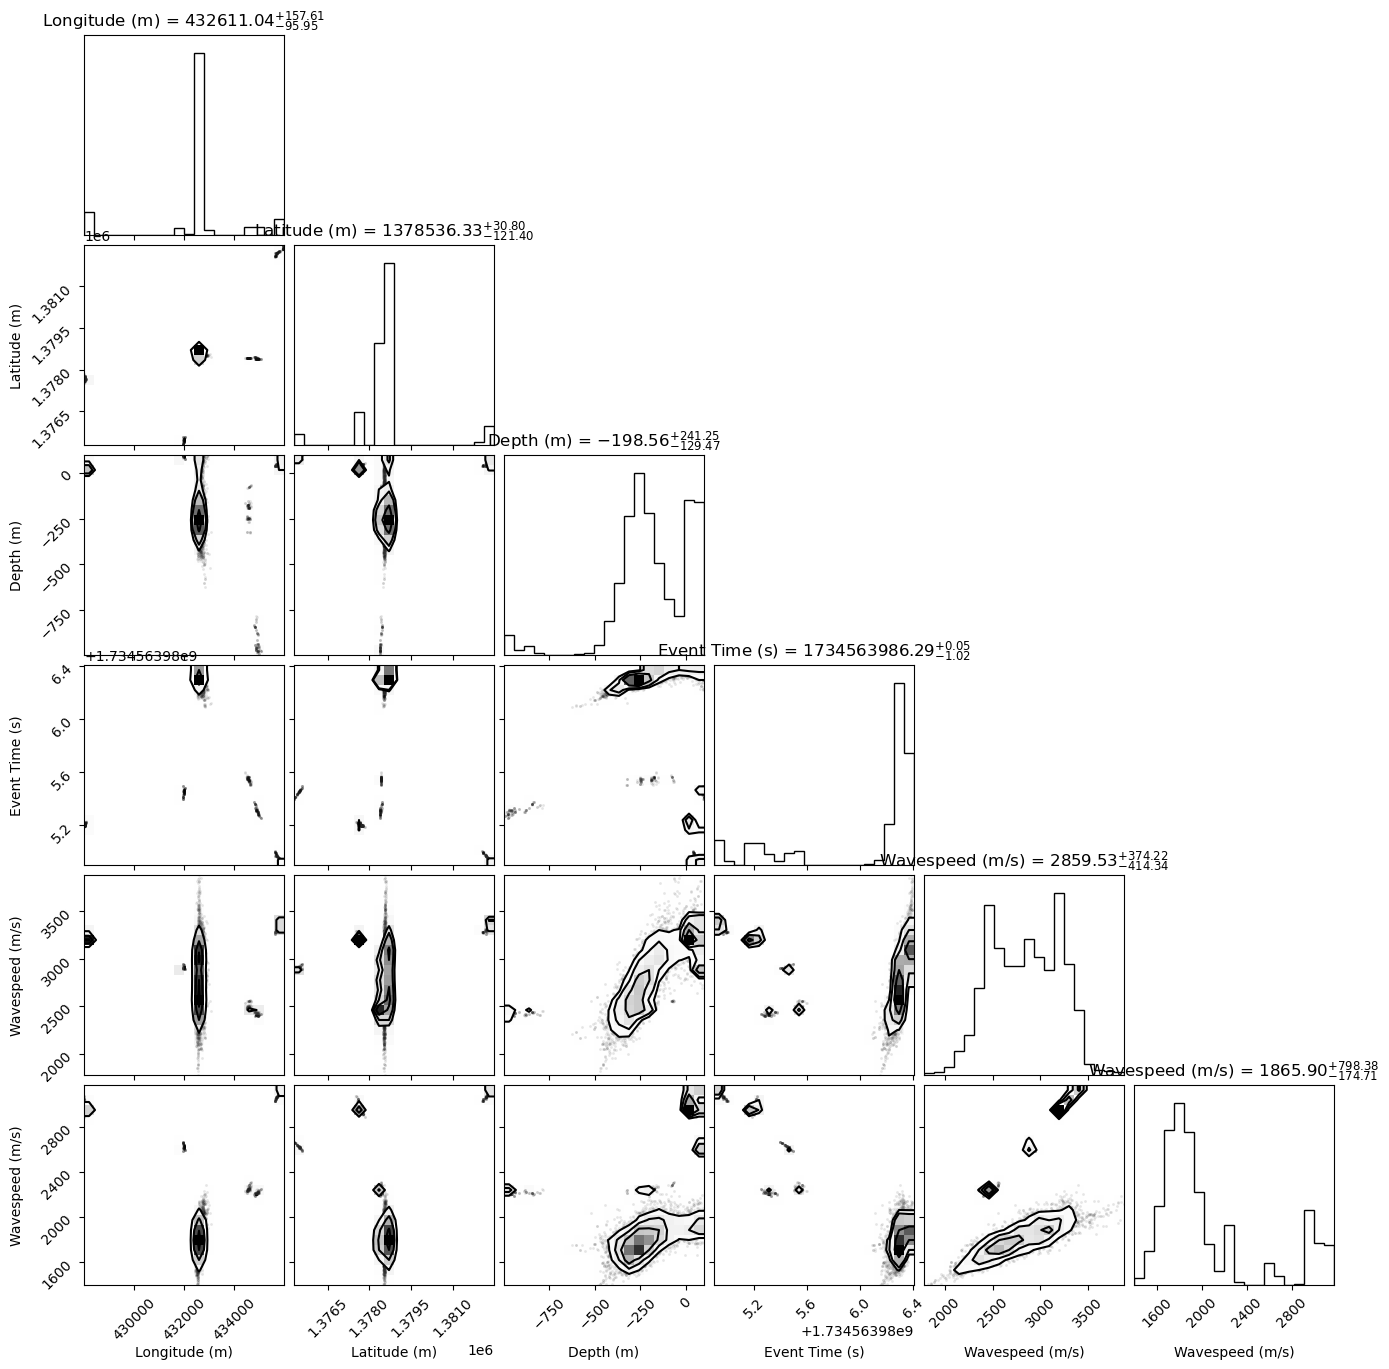

In [157]:
import corner

fig = corner.corner(
    flat_samples, show_titles=True, labels=labels
);

### 9.6 Plot the results

In [162]:
median_x = np.median(flat_samples[:,0])
median_y = np.median(flat_samples[:,1])
median_z = np.median(flat_samples[:,2])
median_offset = np.median(flat_samples[:,3])
median_c = np.median(flat_samples[:,4])

xy_locs = np.vstack([flat_samples[:,0],flat_samples[:,1]])
z_locs = gaussian_kde(xy_locs)(xy_locs)

cable_mean_x = np.mean(channel_locations[:,0])
cable_mean_y = np.mean(channel_locations[:,1])

horizontal_distance = np.sqrt((flat_samples[:,0]-cable_mean_x)**2 + (flat_samples[:,1]-cable_mean_y)**2)

xyz_locs = np.vstack([horizontal_distance, flat_samples[:,2]])
depth_locs = gaussian_kde(xyz_locs)(xyz_locs)

coord_of_best = z_locs.argmax()
x_best = flat_samples[coord_of_best,0]
y_best = flat_samples[coord_of_best,1]

distance_best = np.sqrt((x_best-cable_mean_x)**2 + (y_best-cable_mean_y)**2)
coord_of_best_z = depth_locs.argmax()
z_best = flat_samples[coord_of_best_z,2]

xyz2_locs = np.vstack([flat_samples[:,0], flat_samples[:,2]])
depth2_locs = gaussian_kde(xyz2_locs)(xyz2_locs)
coord_of_best_z2 = depth2_locs.argmax()
z2_best = flat_samples[coord_of_best_z2,2]

(431120.95046839607, 434120.95046839607)

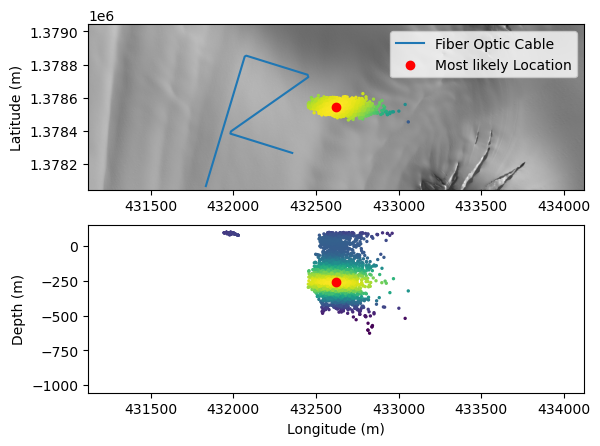

In [170]:
# Median inversion on the source location

fig,ax = plt.subplots(2,1)

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax[0]) 


ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c=z_locs, s=2, alpha = 1)
ax[0].plot(channel_locations[:,0], channel_locations[:,1], label='Fiber Optic Cable')
ax[0].scatter([x_best], [y_best], c='red', label='Most likely Location')
ax[0].set_ylim([y_best-500, y_best+500])
ax[0].set_xlim([x_best-1500, x_best+1500])
ax[0].set_ylabel('Latitude (m)')
ax[0].legend()

ax[1].scatter(flat_samples[:,0], flat_samples[:,2], c=depth2_locs, s=2, alpha = 1)
ax[1].scatter([x_best], [z2_best], c='red')
# ax.set_ylim([1.377e6, 1.38e6])
ax[1].set_xlabel('Longitude (m)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([x_best-1500, x_best+1500])